Can I generate uncertainties for the Phoenix models using Monte Carlo? Is it too computationally expensive?

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
import prepare_phoenix_svo as pp
from timeit import default_timer as timer

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [31]:
params = Table.read('stellar_parameters.csv')

In [32]:
params

Target,RAJ2000,DEJ2000,Jmag,J_e,Hmag,H_e,Kmag,K_e,Rmag,R_e,spt,L_bol,L_bol_e,Mass,Mass_e,Radius,Radius_e,Teff,Teff_e,parallax,distance,P_rot_d
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64
GJ 1132,153.716027,-47.156796,9.245,0.026,8.666,0.031,8.322,0.027,13.098,0.11,M3.5,1.67e+31,5e+29,0.194,0.005,0.215,0.009,3196,72,83.07,12.03804021,126.59
GJ 676A,262.546646,-51.637012,6.711,0.02,6.082,0.024,5.825,0.029,8.675,0.012,M0,3.404e+32,8.3e+30,0.631,0.017,0.62,0.03,4014,94,63.07,15.85539876,41.2
GJ 15A,4.594036,44.022842,5.252,0.264,4.476,0.2,4.018,0.02,7.9,0.012,M1,8.61e+31,7e+29,0.393,0.009,0.385,0.002,3601,12,280.74,3.562014676,-1.0
GJ 649,254.536873,25.74423,6.448,0.021,5.865,0.02,5.624,0.016,8.685,0.012,M1,1.674e+32,1.7e+30,0.524,0.012,0.531,0.012,3621,41,96.38,10.3755966,-1.0
GJ 163,62.315307,-53.373737,7.948,0.026,7.428,0.04,7.135,0.021,10.734,0.012,M3.5,8.28e+31,2.4e+30,0.405,0.01,0.409,0.017,3460,76,66.59,15.01726986,61.0
GJ 849,332.417906,-4.640765,6.51,0.024,5.899,0.044,5.594,0.017,9.279,0.012,M3.5,1.105e+32,1e+30,0.465,0.011,0.464,0.018,3492,70,113.25,8.830022075,39.2
GJ 674,262.166316,-46.89513,5.711,0.019,5.154,0.033,4.855,0.018,8.337,0.012,M2.5,6.03e+31,1.4e+30,0.353,0.008,0.361,0.012,3404,59,220.24,4.540501271,32.9
GJ 699,269.452044,4.694597,5.244,0.02,4.834,0.034,4.524,0.02,8.298,0.012,M4,1.3e+31,2e+29,0.161,0.004,0.187,0.001,3223,17,548.31,1.823785815,130.4
L 980-5,215.313034,-1.122204,8.948,0.03,8.391,0.031,8.093,0.026,13.02,0.15,M3.5,2.49e+31,8e+29,0.232,0.006,0.25,0.01,3278,74,74.66,13.39405304,92.23


In [33]:
G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
for m, r, t in zip(params['Mass'], params['Radius'], params['Teff']):
    g = G*(m*M)/(r*R)**2
    g =  g.to(u.cm/u.s**2)
    print(t,np.log10(g.value))
    #print(logg)

3196 5.060992437402149
4014 4.65331360755076
3601 4.861538718661559
3621 4.707209872123922
3460 4.822076034503119
3492 4.772484619083325
3404 4.87082792887964
3223 5.101210290261985
3278 5.007675594849958
3119 5.113824503742217
3248 5.083980902336978
2619 5.292907918630075


In [34]:
from numpy.random import default_rng
rng = default_rng()

[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]


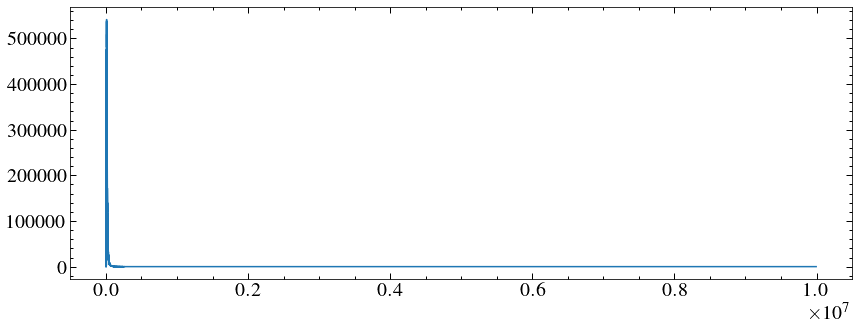

In [35]:
###### pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
#star_params = {'Teff': 2628, 'logg': 5.21, 'FeH': 0.00, 'aM': 0, 'radius':1.16*u.R_jup, 'distance':12.43*u.pc}
G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
save_path = 'interpolated_models/'
# repo = '/media/david/5tb_storage1/muscles/btsettl_models/'
# repo = '/media/david/1tb_storage1/emergency_data/mega_muscles/data-vacuum/'
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'
for row in params[0:1]:
    star = row['Target']
    star = star.replace(' ', '')
    # if star == 'Trappist-1':
        # star = '2MASS-J23062928-0502285'
#     if star != 'Trappist-1':# and star == 'GJ 15A':

  

    g = (G*(row['Mass']*M)/(row['Radius']*R)**2).to(u.cm/u.s**2)
    star_params = {'Teff': row['Teff'], 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':row['Radius']*u.R_sun, 'Distance':row['distance']*u.pc}
    meanw, meanf = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
    plt.plot(meanw, meanf, c='C0', zorder=10)
    # print(row['Mass'], row['Mass_e'])
#     n = 3
#     mdist = rng.normal(row['Mass'], row['Mass_e'], n)
#     tdist = rng.normal(row['Teff'], row['Teff_e'], n)
#     rdist = rng.normal(row['Radius'], row['Radius_e'], n)
# #     start = timer()
    
#     for i in range(n):
#         mi, ti, ri = mdist[i], tdist[i], rdist[i]
#         g = (G*(mi*M)/(ri*R)**2).to(u.cm/u.s**2)
#         star_params = {'Teff': ti, 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':ri*u.R_sun, 'Distance':row['distance']*u.pc}
#         wi, fi = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
#         plt.plot(wi, fi, c='C0', alpha=0.3, zorder=-1)
        
#     end = timer()
#     print(end - start)
    
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.show()
    
    
    # pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=True)

In [36]:
((48/3)*10000)*u.s.to(u.hr)

44.44444444444444

So 44 hours for one star, let alone the storage/memory requirements. May need a different approach. Find out which one has the biggest effect on the SED?

GJ 1132
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
0.9117515192084109
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
1.0901206860037815
radius
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
1.0008858100353502
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH':

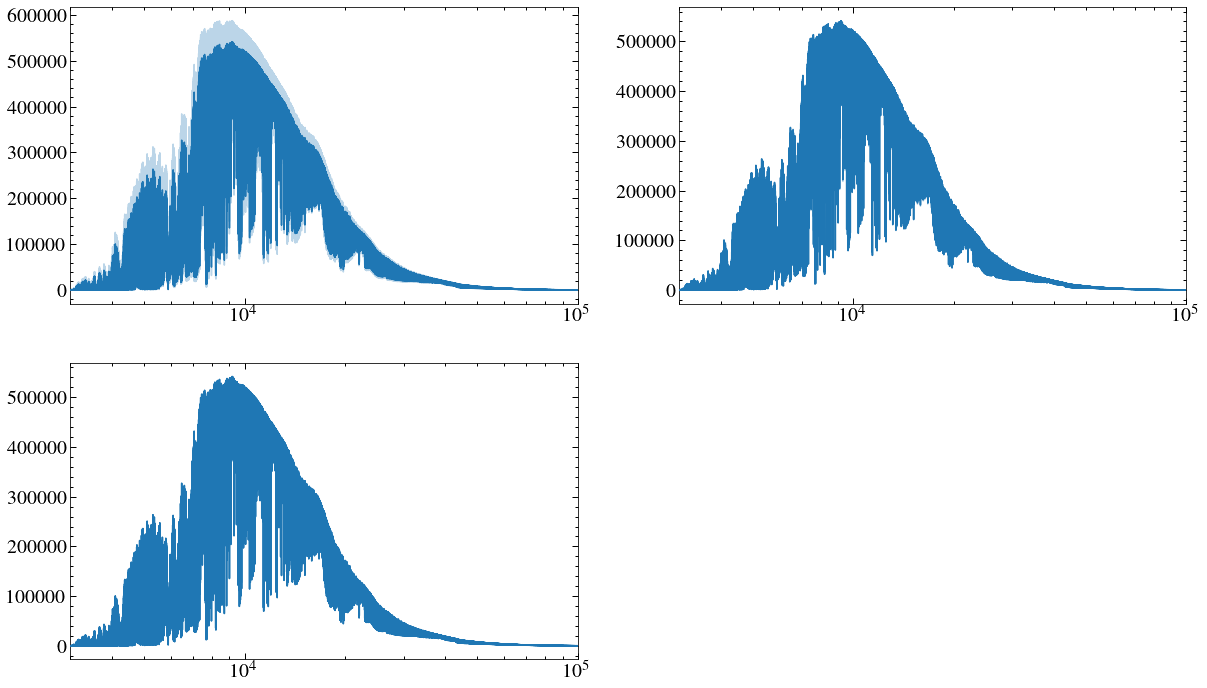

GJ 676A
[{'Teff': 4000, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4000, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4100, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 4100, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4200, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
0.9110144319346833
[{'Teff': 3900, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3900, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4000, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4000, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
1.0985763024136512
radius
[{'Teff': 4000, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4000, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4100, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
1.0007266446982623
[{'Teff': 4000, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 4000, 'logg': 5.0, 'FeH':

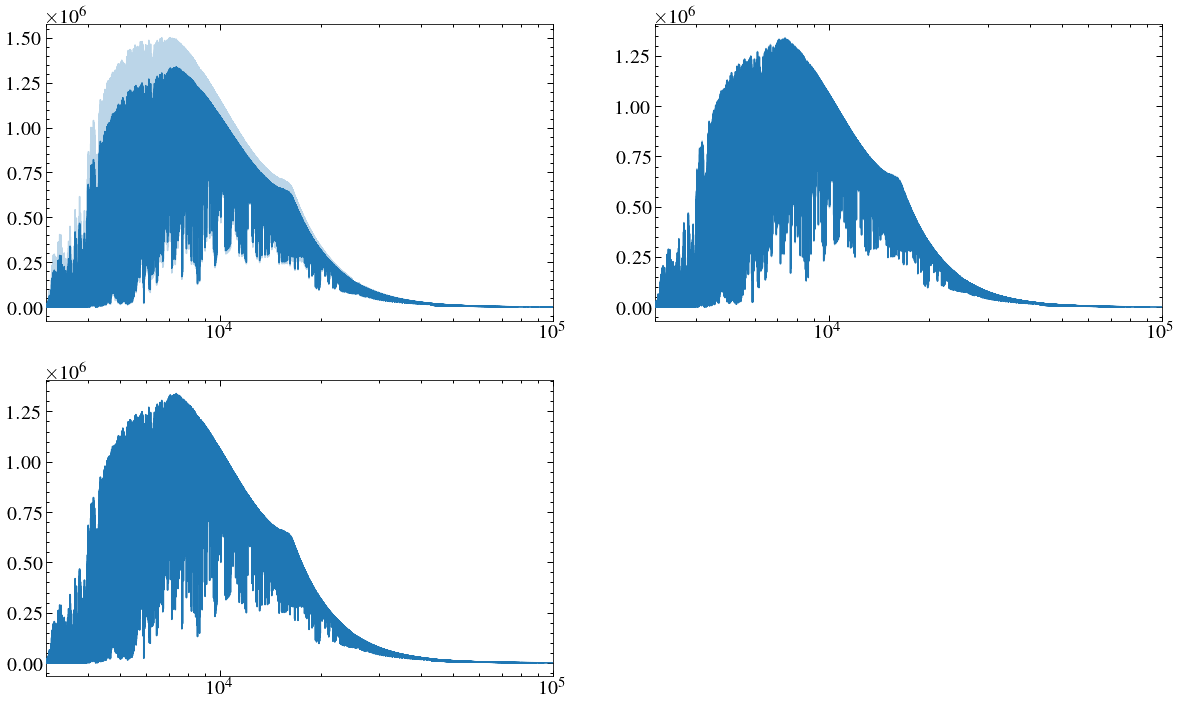

GJ 15A
[{'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
0.9853078365814397
[{'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
1.0134333043417079
radius
[{'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
1.0000386477856418
[{'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 

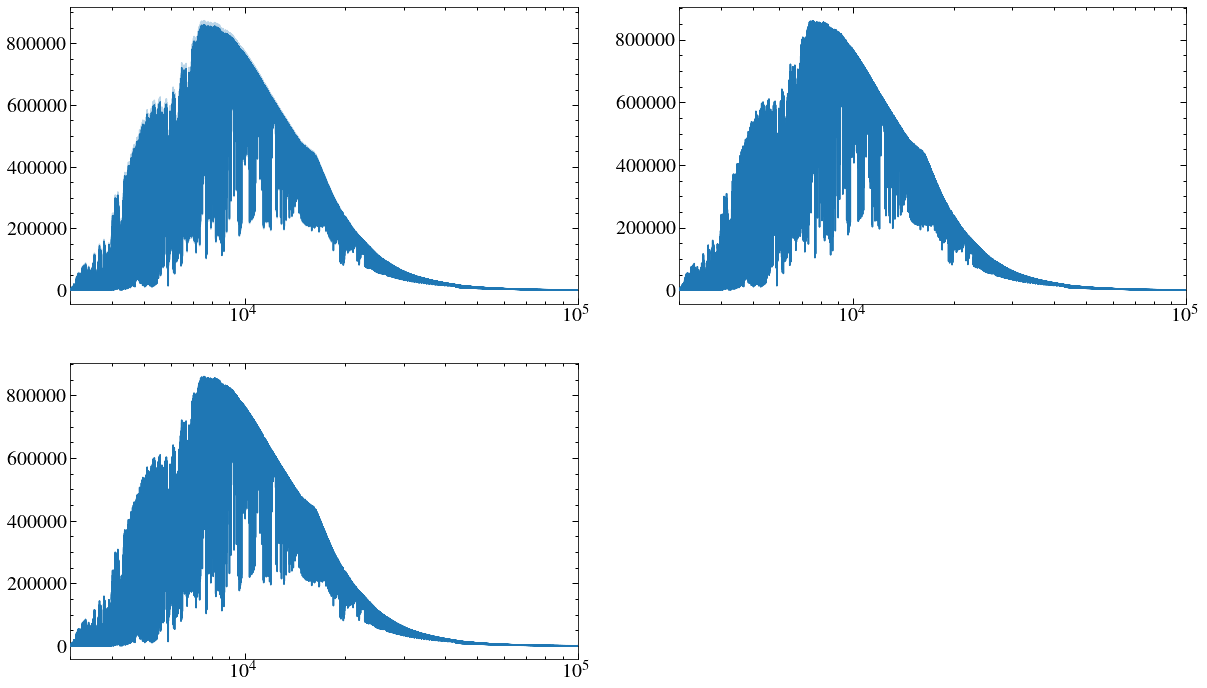

GJ 649
[{'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
0.9536603541059303
[{'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
1.0491351764337415
radius
[{'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3700, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
1.0001628773540172
[{'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 

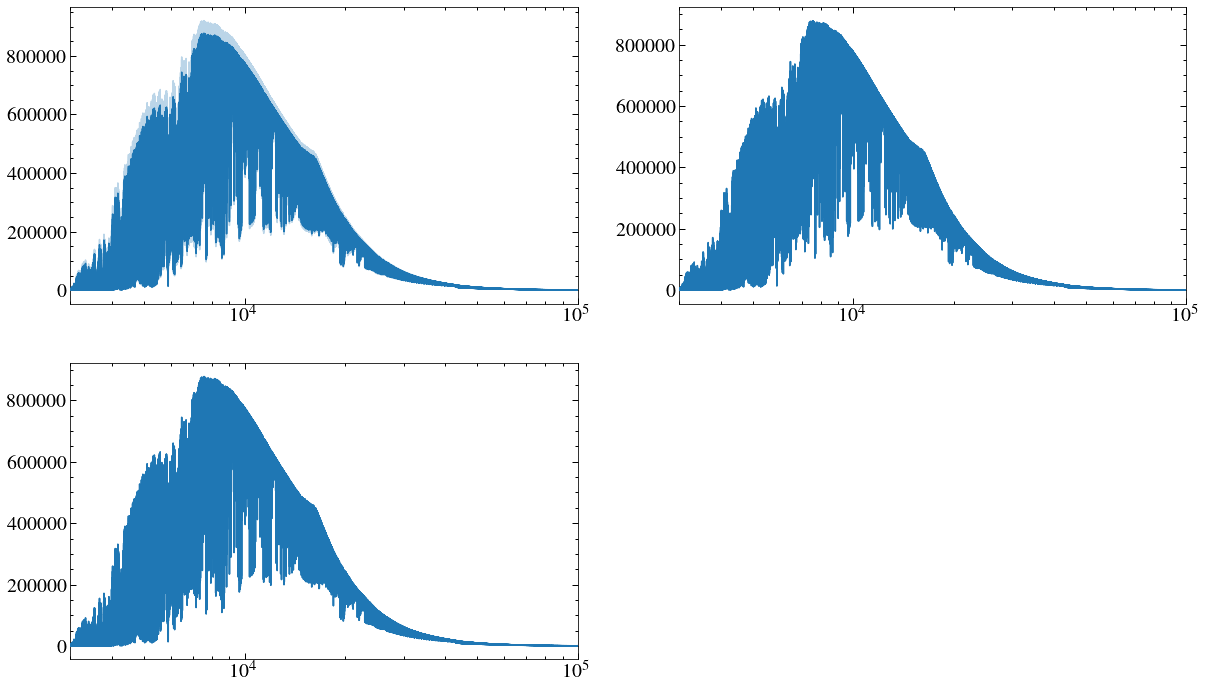

GJ 163
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
0.9147589855602831
[{'Teff': 3300, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
1.094618157305263
radius
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
0.9994050651745352
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0

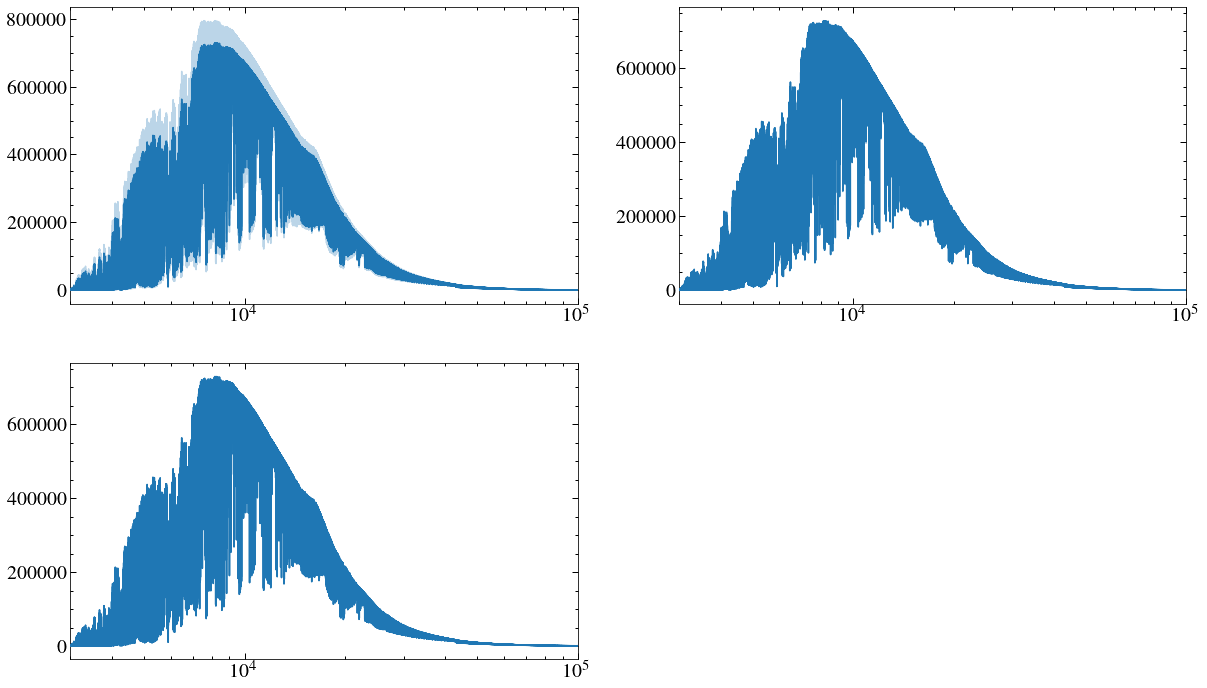

GJ 849
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
0.9172061045536125
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
1.0814671923127586
radius
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
0.9997487308072516
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 

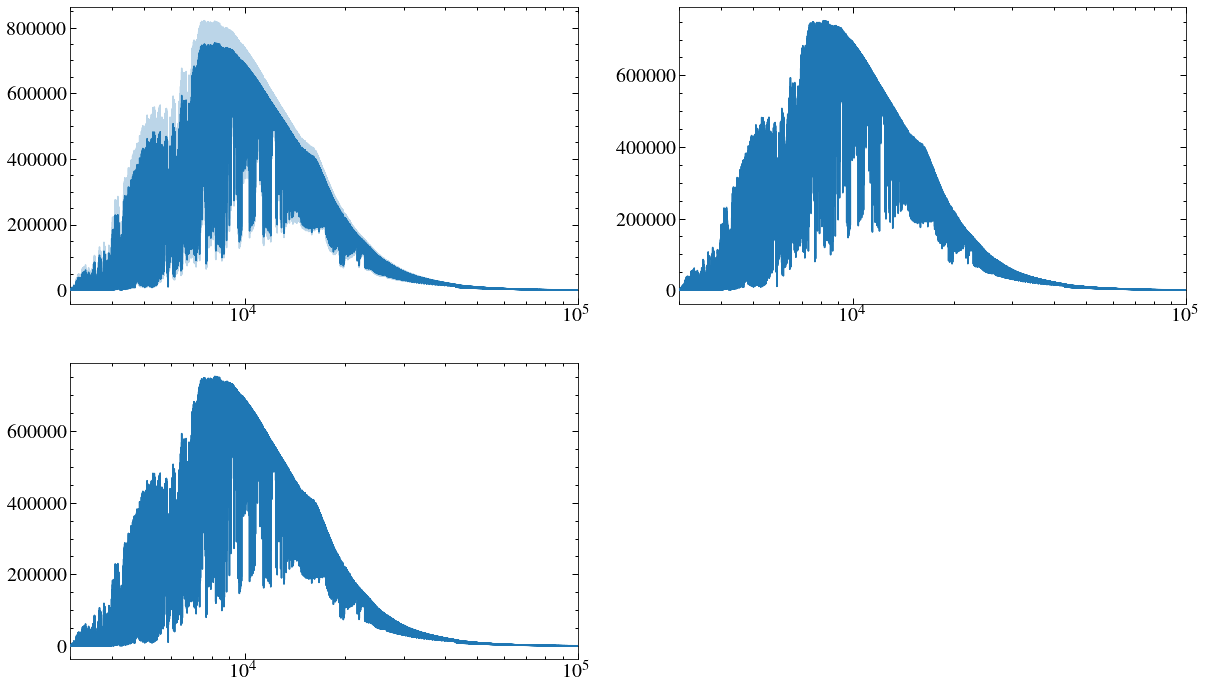

GJ 674
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
0.9321590238592278
[{'Teff': 3300, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
1.0694028598559484
radius
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
0.9993248677324369
[{'Teff': 3400, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 

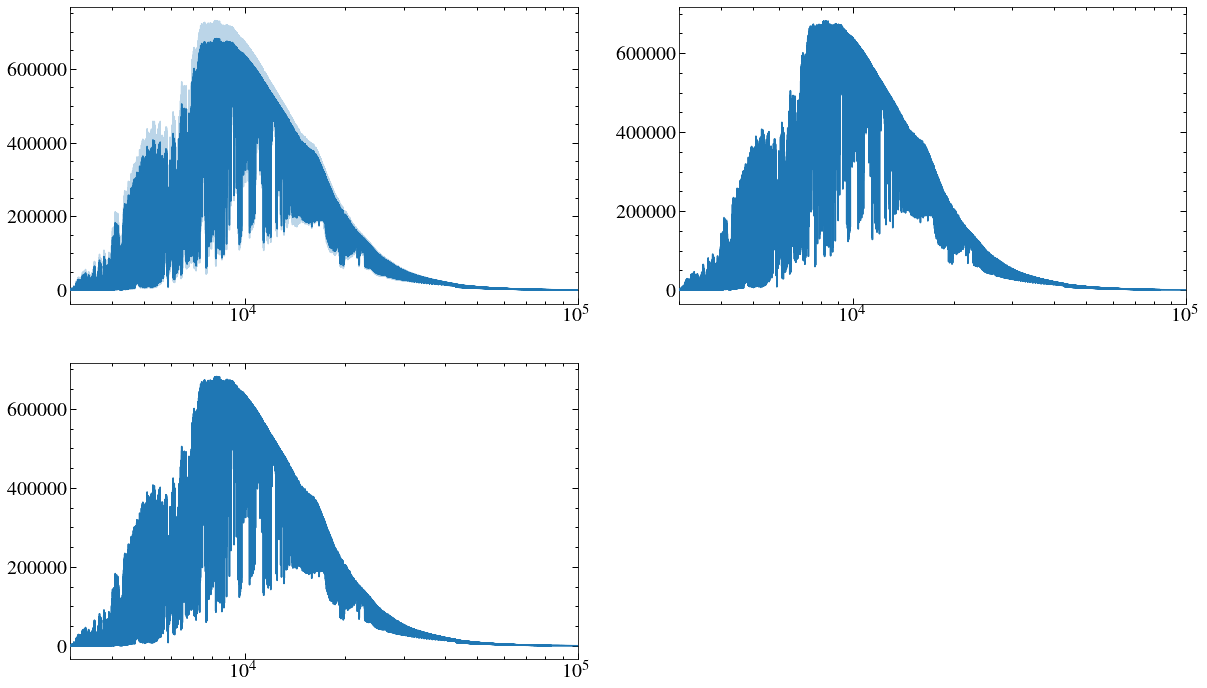

GJ 699
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
0.9779576042757878
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
1.0217156697462104
radius
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
1.000027582527161
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0

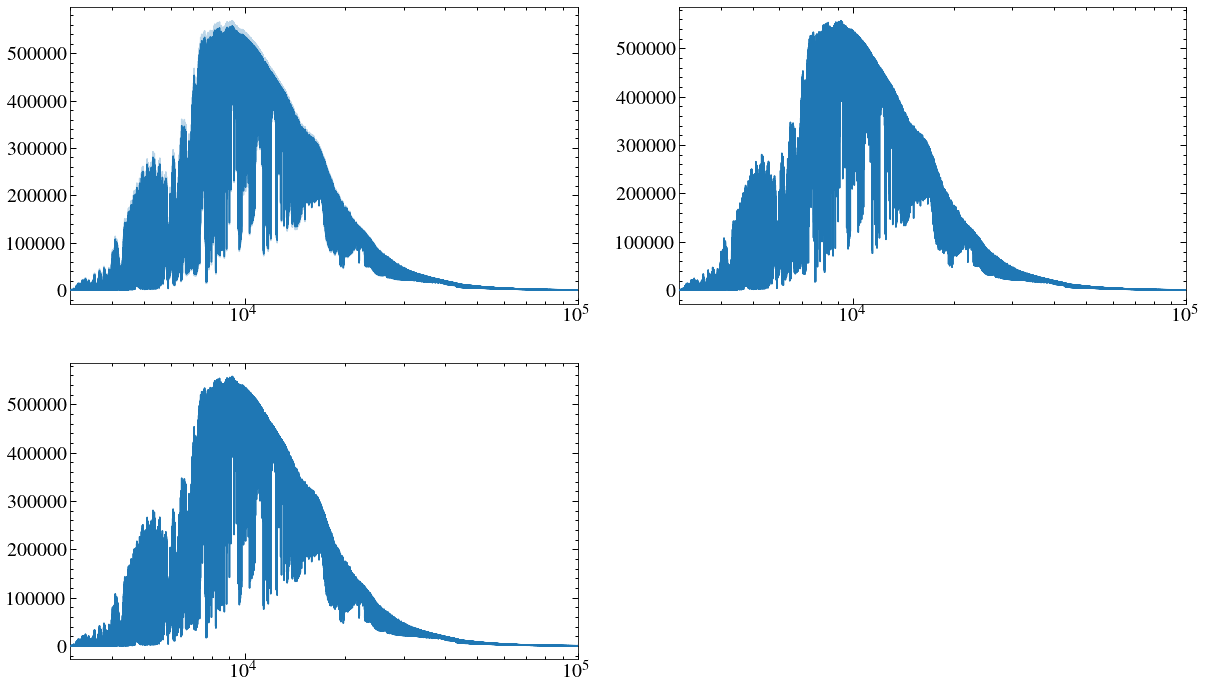

L 980-5
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
0.9178418336151891
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
1.100704798786952
radius
[{'Teff': 3200, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 4.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}]
0.9996046009678633
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 

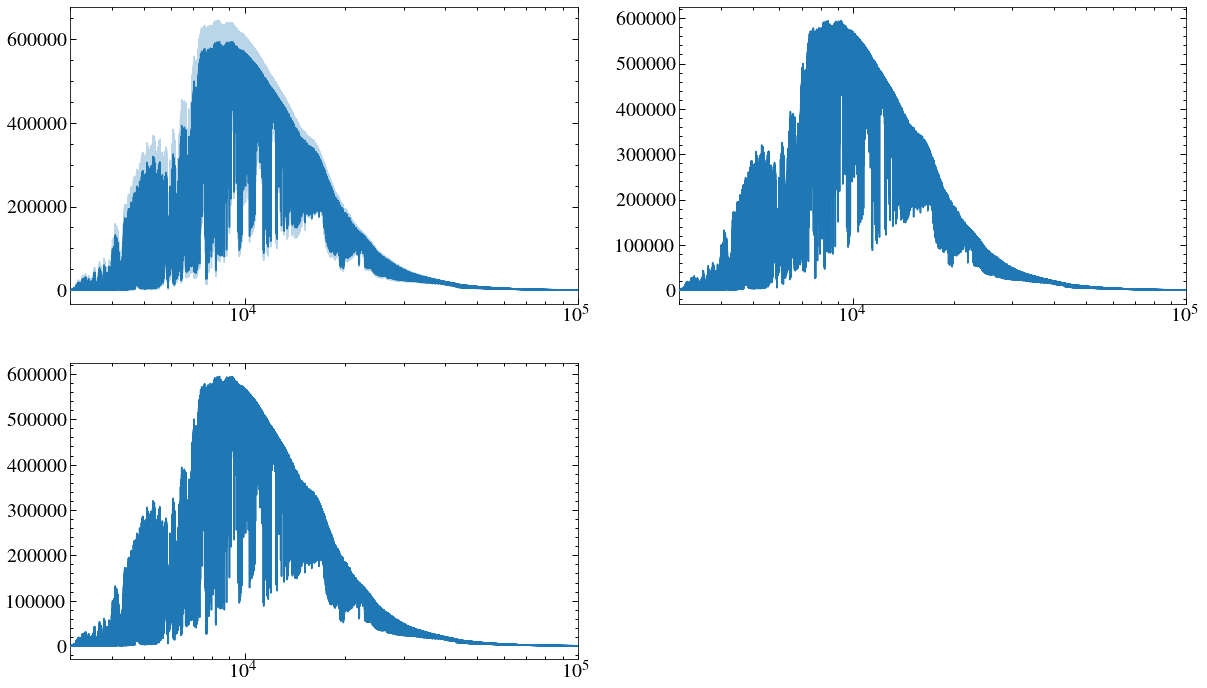

LHS 2686
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
0.918715769674553
[{'Teff': 3000, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3000, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
1.0902732412909815
radius
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
1.0006192593187628
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH':

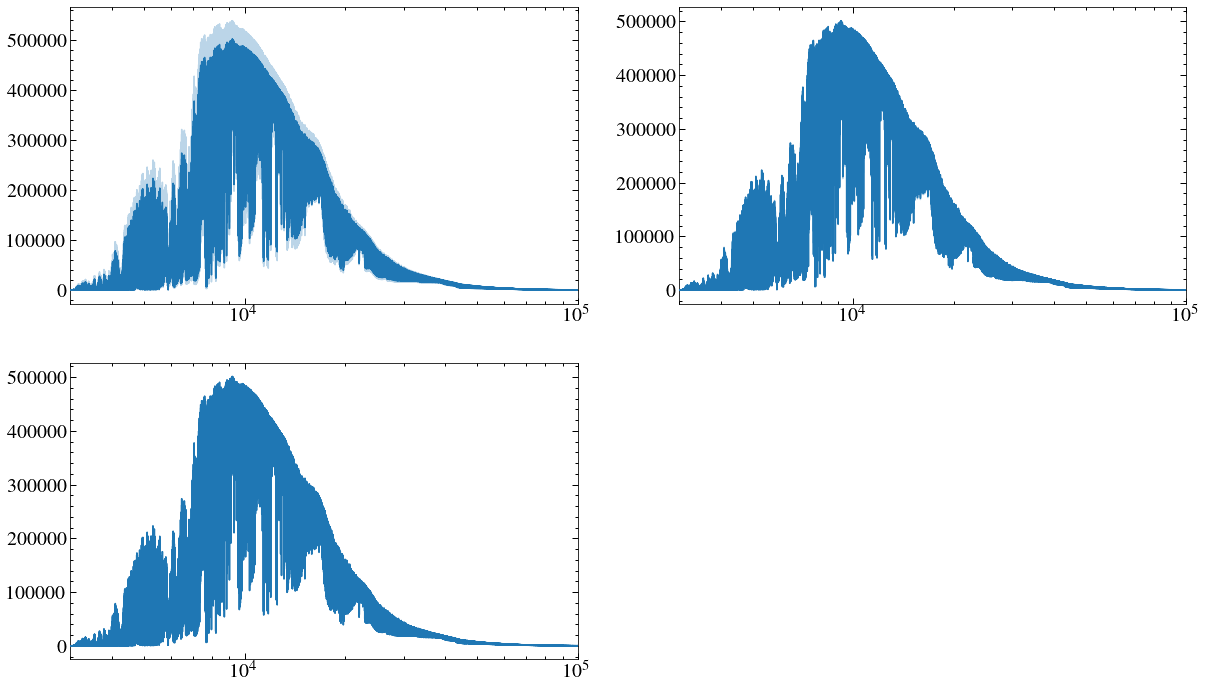

GJ 729
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3400, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
0.9175894657781465
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
1.088861500207282
radius
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
1.0001963832987792
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0

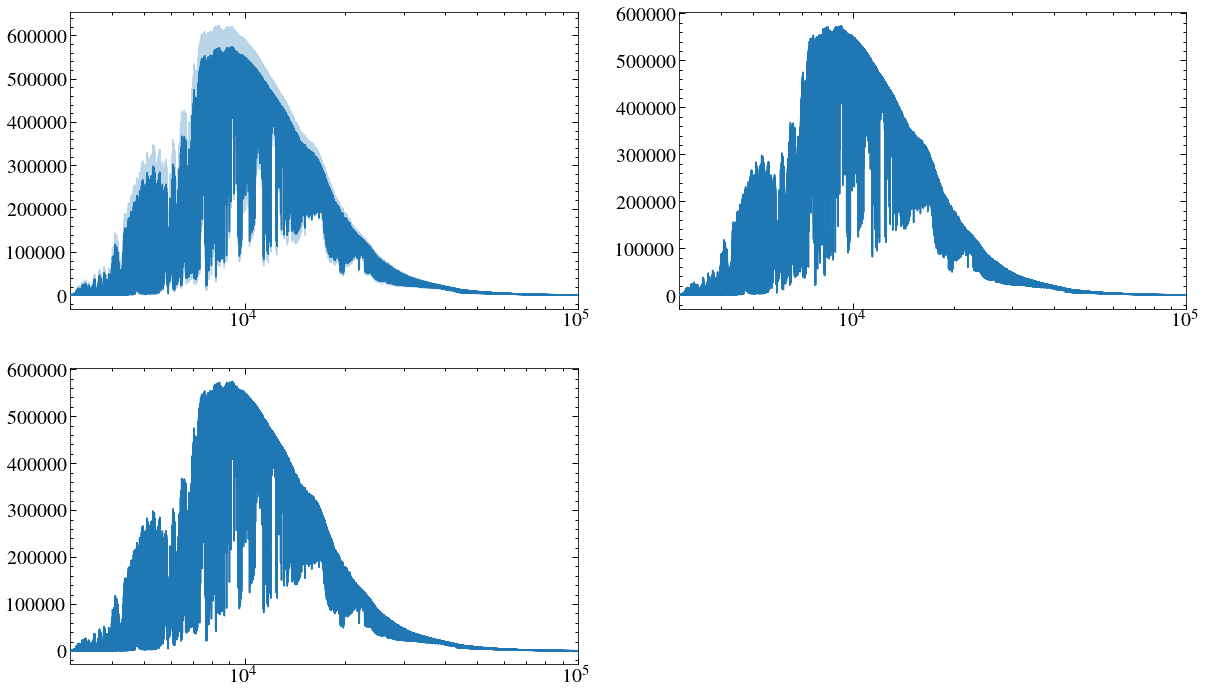

Trappist-1
[{'Teff': 2600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2600, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2700, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2700, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
teff
[{'Teff': 2600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2600, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2700, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2700, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
0.8798066478924397
[{'Teff': 2500, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2500, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2600, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
1.131044810078106
radius
[{'Teff': 2600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2600, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2700, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2700, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
0.9995205297241622
[{'Teff': 2600, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 2600, 'logg': 5.5, 'FeH

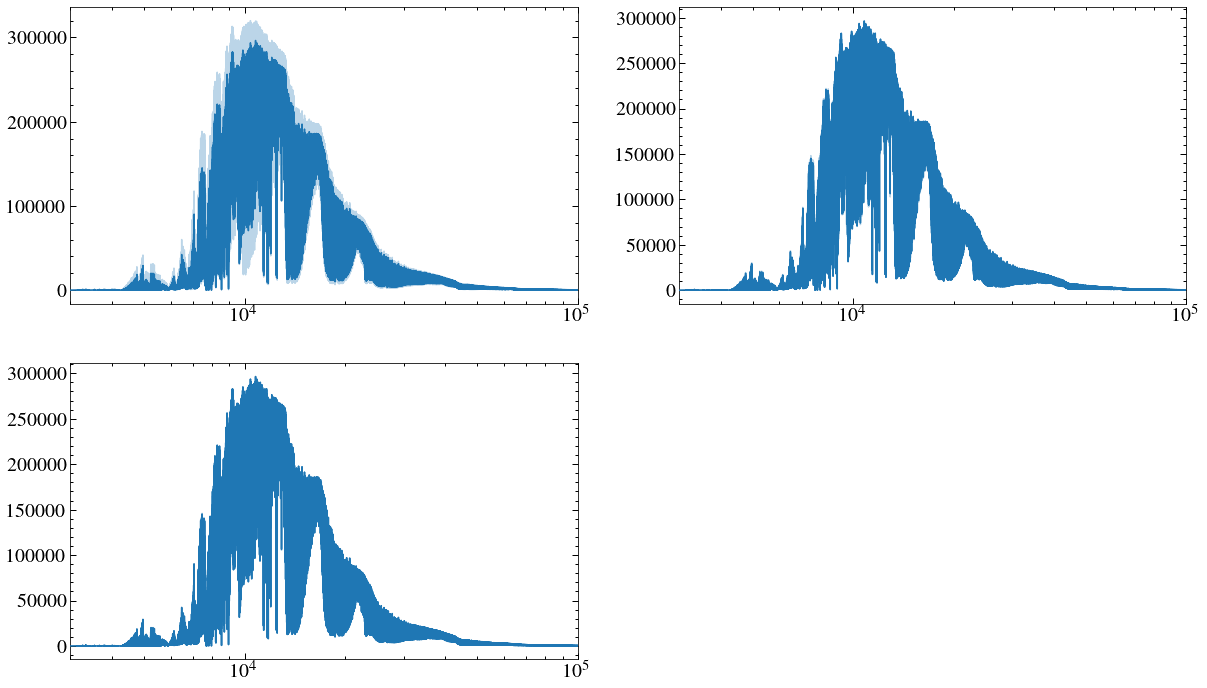

In [45]:
for row in params:
    star = row['Target']
    print(star)
    star = star.replace(' ', '')
    # if star == 'Trappist-1':
        # star = '2MASS-J23062928-0502285'
#     if star != 'Trappist-1':# and star == 'GJ 15A':

    plt.figure(figsize=(20, 12))

    g = (G*(row['Mass']*M)/(row['Radius']*R)**2).to(u.cm/u.s**2)
    star_params = {'Teff': row['Teff'], 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':row['Radius']*u.R_sun, 'Distance':row['distance']*u.pc}
    meanw, meanf = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
    mean_int = np.trapz(meanf, meanw)
    
    #teff
    print('teff')
    plt.subplot(221)
    
    plt.plot(meanw, meanf, c='C0', zorder=10)
    star_params = {'Teff': row['Teff']+row['Teff_e'], 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':row['Radius']*u.R_sun, 'Distance':row['distance']*u.pc}
    wi, fi = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
    print(mean_int/np.trapz(fi, wi))
    plt.plot(wi, fi, c='C0', alpha=0.3, zorder=-1)
    
    star_params = {'Teff': row['Teff']-row['Teff_e'], 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':row['Radius']*u.R_sun, 'Distance':row['distance']*u.pc}
    wi, fi = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
    print(mean_int/np.trapz(fi, wi))
    plt.plot(wi, fi, c='C0', alpha=0.3, zorder=-1)

    plt.xscale('log')
    # plt.yscale('log')
    plt.xlim(3000, 100000)
    
    
    #radius
    print('radius')
    plt.subplot(222)
    
    plt.plot(meanw, meanf, c='C0', zorder=10)
    g = (G*(row['Mass']*M)/((row['Radius']+row['Radius_e'])*R)**2).to(u.cm/u.s**2)
    star_params = {'Teff': row['Teff'], 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':(row['Radius']-row['Radius_e'])*u.R_sun, 'Distance':row['distance']*u.pc}
    wi, fi = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
    print(mean_int/np.trapz(fi, wi))
    plt.plot(wi, fi, c='C0', alpha=0.3, zorder=-1)
    
    g = (G*(row['Mass']*M)/((row['Radius']-row['Radius_e'])*R)**2).to(u.cm/u.s**2)
    star_params = {'Teff': row['Teff'], 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':(row['Radius']-row['Radius_e'])*u.R_sun, 'Distance':row['distance']*u.pc}
    wi, fi = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
    print(mean_int/np.trapz(fi, wi))
    plt.plot(wi, fi, c='C0', alpha=0.3, zorder=-1)

    plt.xscale('log')
    # plt.yscale('log')
    plt.xlim(3000, 100000)
    
        #radius
    print('mass')
    plt.subplot(223)
    
    plt.plot(meanw, meanf, c='C0', zorder=10)
    g = (G*((row['Mass']+row['Mass_e'])*M)/((row['Radius'])*R)**2).to(u.cm/u.s**2)
    star_params = {'Teff': row['Teff'], 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':(row['Radius'])*u.R_sun, 'Distance':row['distance']*u.pc}
    wi, fi = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
    print(mean_int/np.trapz(fi, wi))
    plt.plot(wi, fi, c='C0', alpha=0.3, zorder=-1)
    
    g = (G*((row['Mass']-row['Mass_e'])*M)/((row['Radius'])*R)**2).to(u.cm/u.s**2)
    star_params = {'Teff': row['Teff'], 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':(row['Radius'])*u.R_sun, 'Distance':row['distance']*u.pc}
    wi, fi = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
    print(mean_int/np.trapz(fi, wi))
    plt.plot(wi, fi, c='C0', alpha=0.3, zorder=-1)

    plt.xscale('log')
    # plt.yscale('log')
    plt.xlim(3000, 100000)
    
    
    plt.show()
    
    

So only teff has an effect? Yay can just use Teff!